# Amazon Alexa Review - Sentiment Analysis

In [1]:
pip install scikit-learn==1.5.1

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Analyzing the Amazon Alexa dataset and building classification  models to predict if the sentiment of a given input sentence is postive and negative.

# Import required libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aybha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


In [5]:
data = pd.read_csv(r"Data\amazon_alexa.tsv", delimiter='\t', quoting=3)
data.shape  #The shape attribute should not be called as a function. Instead, it should be accessed directly without parentheses.

(3150, 5)

In [6]:
data.head()


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [7]:
data.tail()

,rating,date,variation,verified_reviews,feedback
3145,5,30-Jul-18,Black Dot,"""Perfect for kids, adults and everyone in betw...",1
3146,5,30-Jul-18,Black Dot,"""Listening to music, searching locations, chec...",1
3147,5,30-Jul-18,Black Dot,"""I do love these things, i have them running m...",1
3148,5,30-Jul-18,White Dot,"""Only complaint I have is that the sound quali...",1
3149,4,29-Jul-18,Black Dot,Good,1


In [8]:
data.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [9]:
# columns name -----This will return the column names of the DataFrame as a numpy array
data.columns.values


array(['rating', 'date', 'variation', 'verified_reviews', 'feedback'],
      dtype=object)

In [10]:
data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    2
feedback            0
dtype: int64

In [11]:
#Getting record where verified_review is NULL  ---Your approach to 
#filtering rows where the verified_reviews column is null is correct, 
#but you can simplify the condition to data['verified_reviews'].isna(). 

data[data['verified_reviews'].isna() == True]
#This will return the rows in the DataFrame where the verified_reviews column contains NaN values.

,rating,date,variation,verified_reviews,feedback
145,3,30-Jul-18,Sandstone Fabric,NaN,1
2982,5,30-Jul-18,Black Dot,NaN,1


In [12]:
data.dropna(inplace=True)

In [13]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3148, 5)


In [14]:
#create new column length that will contain the length of the strings in verified_reviews column  
data['length']=data['verified_reviews'].apply(len)

In [15]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [16]:
# Randomly checking for 10th record
print(f"'verified_reviews' column value:{data.iloc[10]['verified_reviews']}")  # Original value
print(f"Length of review: {len(data.iloc[10]['verified_reviews'])}")  # Length of review using len()
print(f"length column value: {data.iloc[10]['length']}")  # Value of the column 'length'


'verified_reviews' column value:"I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review: 65
length column value: 65


In [17]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [18]:
print(f"Total recodes :{len(data)}")

Total recodes :3148


In [19]:
#counts rating 
print(f"Rating value count:\n{data['rating'].value_counts()}")

Rating value count:
5    2285
4     455
1     161
3     151
2      96
Name: rating, dtype: int64


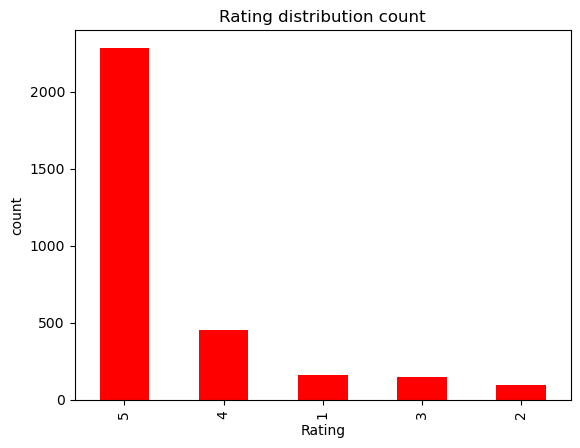

In [20]:
#Bar plot to visualize the total counts of each rating 
data['rating'].value_counts().plot.bar(color='red')
plt.title('Rating distribution count')
plt.xlabel('Rating')
plt.ylabel('count')
plt.show()

In [21]:
#finding the percentage distribution of each rating -- we will divide the number of records for each rating by total number of records
print(f"Rating distribution count - Percentage distriution :\n {round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating distribution count - Percentage distriution :
 5    72.59
4    14.45
1     5.11
3     4.80
2     3.05
Name: rating, dtype: float64


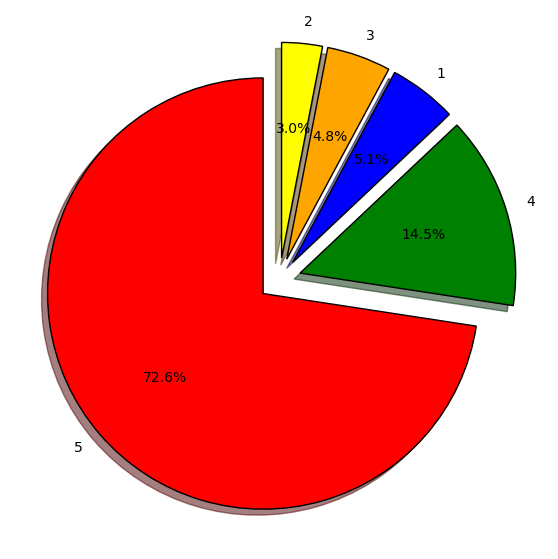

In [22]:
#lets plot the above values in a pie chart  
fig = plt.figure(figsize=(7, 7))
colors = ('red', 'green', 'blue', 'orange', 'yellow')
wp = {'linewidth': 1, 'edgecolor': 'black'}
tags = data['rating'].value_counts() / data.shape[0]
explode = (0.1, 0.1, 0.1, 0.1, 0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')

from io import BytesIO
graph = BytesIO()
fig.savefig(graph, format="png")

# To display the plot inline if using a Jupyter notebook, you might need this:
plt.show()


# Analyzing feedback column

In [23]:
#Distinct values of feedback and its count    1-- feedback yes 0-- No feedback
print(f"Feedback values count : \n {data['feedback'].value_counts()}")

Feedback values count : 
 1    2891
0     257
Name: feedback, dtype: int64


In [24]:
review_0=data[data['feedback']==0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [25]:
review_1=data[data['feedback']==1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


from above 2 example we can see that feedback 0 is the negative and 1 is the positive feedback 

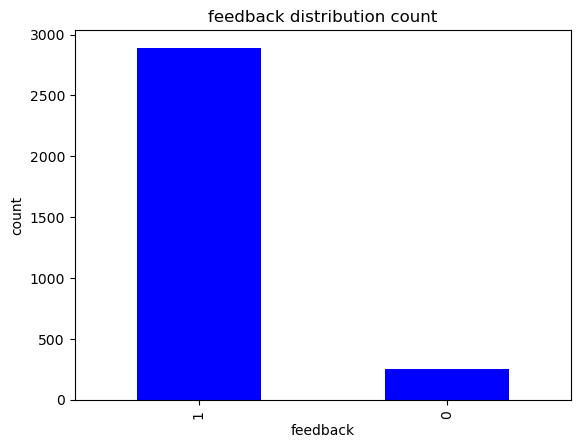

In [26]:
#Bar plot to visualize the total counts of each feedback 
data['feedback'].value_counts().plot.bar(color='blue')
plt.title('feedback distribution count')
plt.xlabel('feedback')
plt.ylabel('count')
plt.show()

In [27]:
#finding the percentage distribution of each feedback -- we will divide the number of records for each feedback by total number of records
print(f"feedback distribution count - Percentage distriution :\n {round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

# Calculate the percentage distribution of each feedback
#feedback_distribution = round(data['feedback'].value_counts() / data.shape[0] * 100, 2)
#print(f"Feedback distribution count - Percentage distribution:\n{feedback_distribution}")

feedback distribution count - Percentage distriution :
 1    91.84
0     8.16
Name: feedback, dtype: float64


feedback distribution -- percentage distribution 
91.84 -- positive 
8.16 -- negative 

<Axes: ylabel='Percentage'>

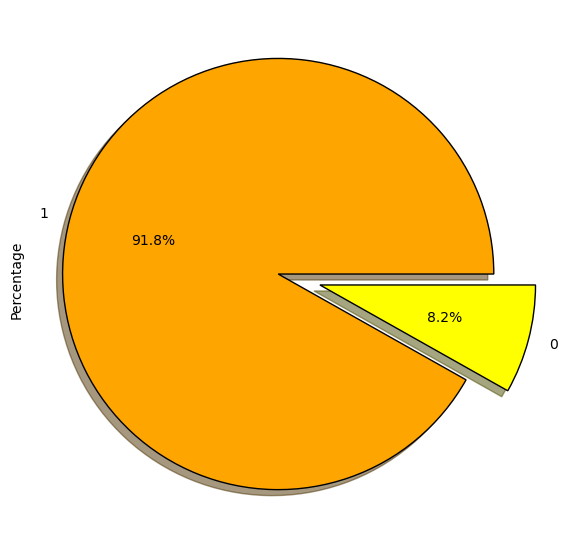

In [28]:
# Plot the feedback distribution as a pie chart
fig = plt.figure(figsize=(7, 7))
colors = ('orange', 'yellow')
wp = {'linewidth': 1, 'edgecolor': 'black'}
tags=data['feedback'].value_counts()/data.shape[0]
explode=(0.1,0.1)



tags.plot(kind='pie',label='Percentage',explode=explode,colors=colors,wedgeprops=wp,autopct="%1.1f%%", shadow=True)

In [29]:
#feedback -- 0
print('Rating')
data[data['feedback']==0]['rating'].value_counts()

Rating


1    161
2     96
Name: rating, dtype: int64

In [30]:
#feedback -- 0
data[data['feedback']==1]['rating'].value_counts()

5    2285
4     455
3     151
Name: rating, dtype: int64

if the rating of a review is 1 or 2 then the feedback is negative(0) and if the rating is 3,4,5 then then feedback is 1 postive.

# Variation column

this columnn refer to the variation or type of Amazon Alexa product  example -- BlackDot,charcol Fabric etc.

In [31]:
data['variation'].value_counts()

Black  Dot                      515
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 89
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

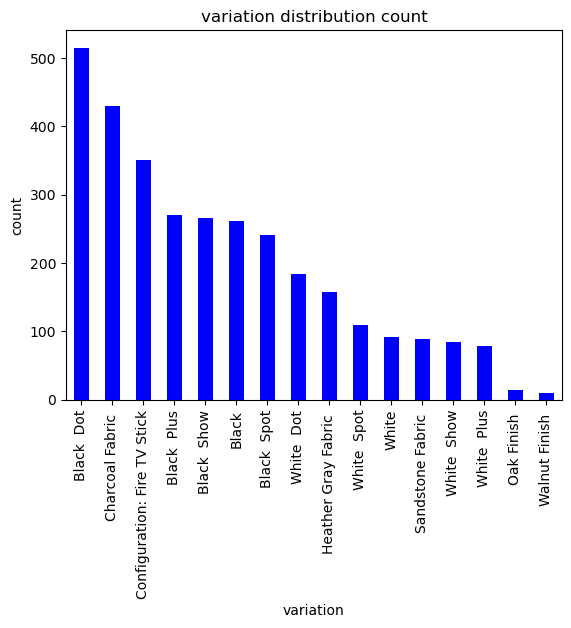

In [32]:
#Bar plot to visualize the total counts of each variation
data['variation'].value_counts().plot.bar(color='blue')
plt.title('variation distribution count')
plt.xlabel('variation')
plt.ylabel('count')
plt.show()

In [33]:
#finding the percentage distribution of each rating -- we will divide the number of records for each rating by total number of records
print(f"variation distribution count - Percentage distriution :\n{round(data['variation'].value_counts()/data.shape[0]*100,2)}")

variation distribution count - Percentage distriution :
Black  Dot                      16.36
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.12
Black  Plus                      8.58
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.66
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
White                            2.89
Sandstone Fabric                 2.83
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: variation, dtype: float64


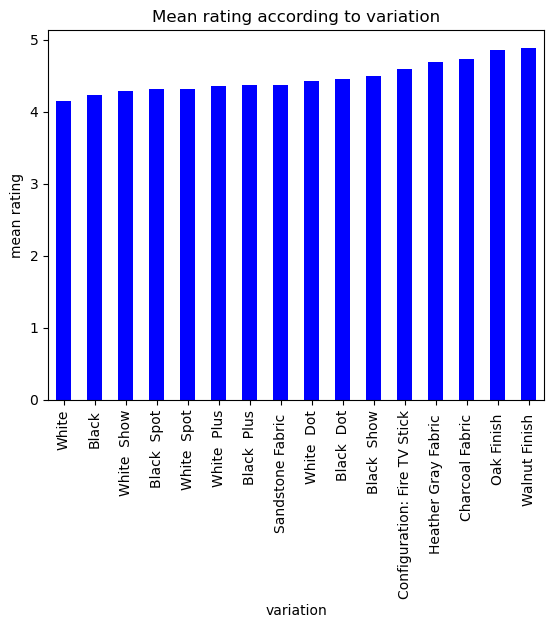

In [34]:
#avg rating of every variation 
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='blue')
plt.title('Mean rating according to variation')
plt.xlabel('variation')
plt.ylabel('mean rating')
plt.show()

# length


In [35]:
data['length'].describe()

count    3148.000000
mean      132.669949
std       182.575737
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Distribution of the length of review')]

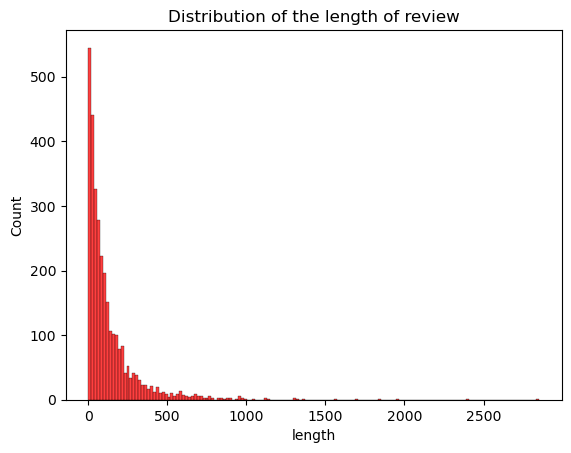

In [36]:
sns.histplot(data['length'], color='red').set(title='Distribution of the length of review')

[Text(0.5, 1.0, 'Distribution of the length of review if feedback=0')]

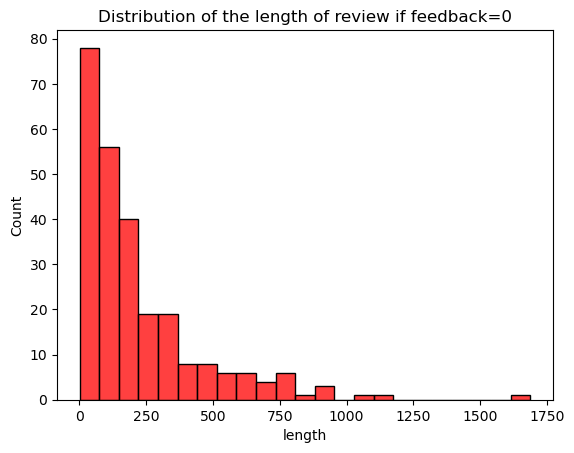

In [37]:
sns.histplot(data[data['feedback']==0]['length'], color='red').set(title='Distribution of the length of review if feedback=0')

[Text(0.5, 1.0, 'Distribution of the length of review if feedback=1')]

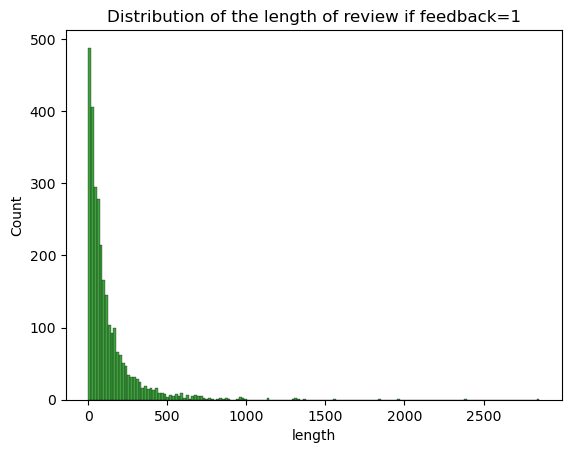

In [38]:
sns.histplot(data[data['feedback']==1]['length'], color='green').set(title='Distribution of the length of review if feedback=1')

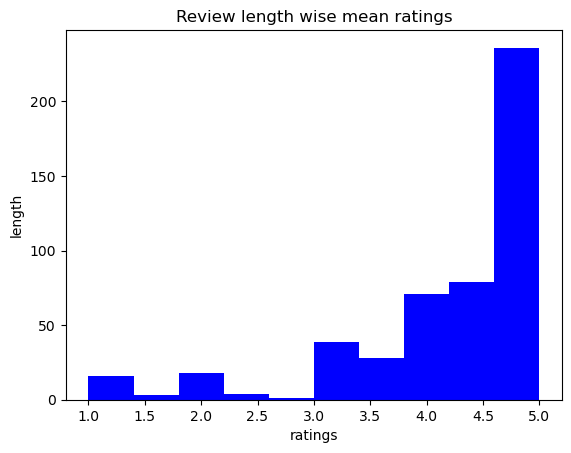

In [39]:
#lenth wise mean rating 
data.groupby('length')['rating'].mean().plot.hist(color='blue')
plt.title('Review length wise mean ratings')
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [40]:
# Initialize CountVectorizer
cv = CountVectorizer(stop_words='english')

# Fit and transform the data
cv.fit_transform(data['verified_reviews'])

<3148x3784 sparse matrix of type '<class 'numpy.int64'>'
	with 32986 stored elements in Compressed Sparse Row format>

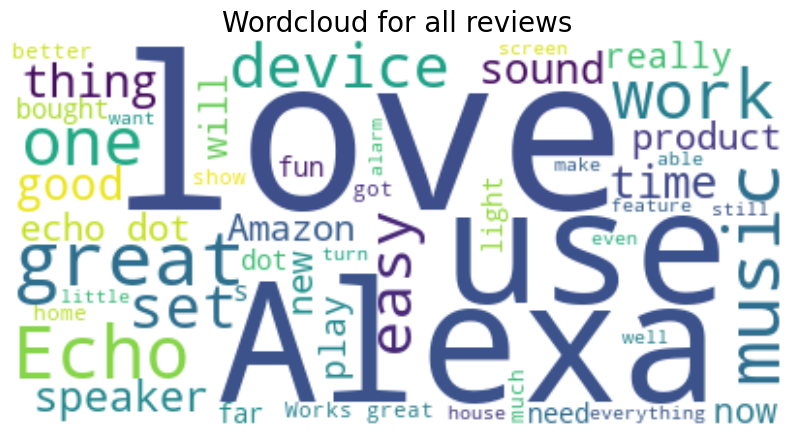

In [41]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(reviews), interpolation='bilinear')
plt.title('Wordcloud for all reviews', fontsize=20)
plt.axis('off')
plt.show()

In [42]:
# Combine all reviews for each feedback category and split them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

# Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)





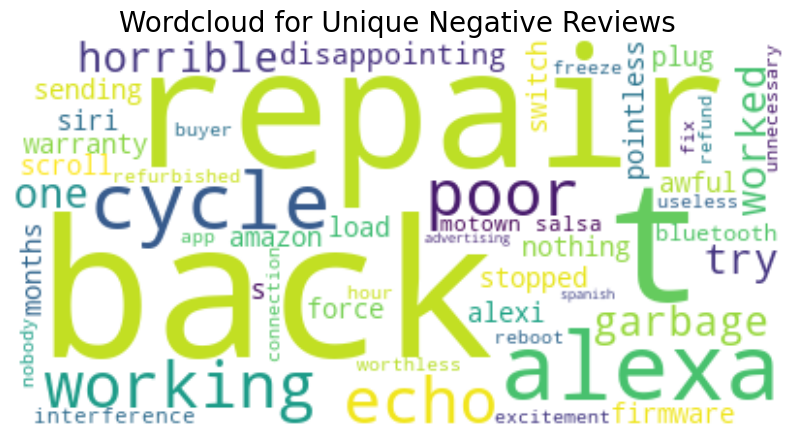

In [43]:
# Initialize WordCloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud for unique negative words
plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(unique_negative), interpolation='bilinear')
plt.title('Wordcloud for Unique Negative Reviews', fontsize=20)
plt.axis('off')
plt.show()

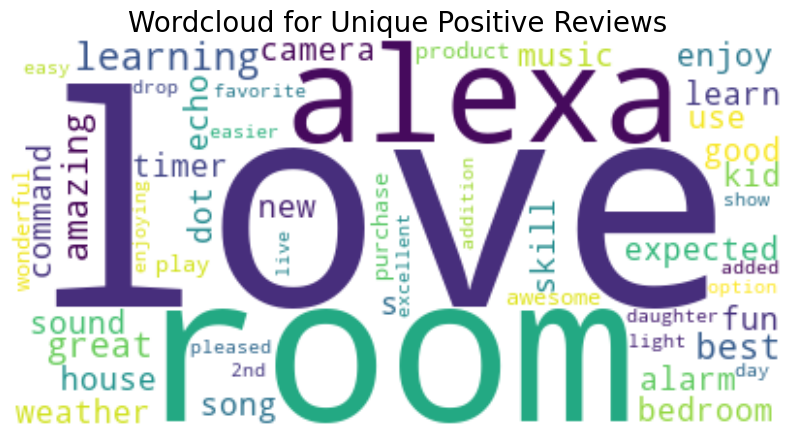

In [44]:
# Generate and plot wordcloud for unique positive words
plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(unique_positive), interpolation='bilinear')
plt.title('Wordcloud for Unique Positive Reviews', fontsize=20)
plt.axis('off')
plt.show()

# Preprocessing and Modelling


To build the corpus from the 'verified_reviews' we perform the following -
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form

In [45]:
# Initialize stemmer
stemmer = PorterStemmer()

# Define the corpus
corpus = []

# Iterate over each review
for i in range(0, data.shape[0]):
    # Replace non-alphabet characters with a space
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]["verified_reviews"])
    # Convert to lowercase and split into words
    review = review.lower().split()
    # Remove stopwords and apply stemming
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    # Join the processed words back into a single string
    review = ' '.join(review)
    # Add the processed review to the corpus
    corpus.append(review)


Using count vectorzier to create bag of words

In [46]:

# Initialize CountVectorizer with a maximum of 2500 features
cv = CountVectorizer(max_features=2500)

# Fit and transform the corpus to create the bag of words model
X = cv.fit_transform(corpus).toarray()
y=data['feedback'].values

# Optional: Show the shape of the resulting matrix
print(X.shape)

(3148, 2500)


In [47]:

# Save the CountVectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

# Print the shapes of X and y
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3148, 2500)
y shape: (3148,)


Splitting data into train and test set with 30% data with testing

In [48]:
# Split the data into training and testing sets with 30% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

# Print the shapes of the training and testing datasets
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (2203, 2500)
y train: (2203,)
X test: (945, 2500)
y test: (945,)


In [49]:
# Print the maximum values in X_train and X_test
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [50]:
# Scale X_train and X_test so that all values are between 0 and 1
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)


In [51]:
# Save the scaler
import pickle

scaler_filename = "scaler.pkl"
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
print(f"Scaler saved to {scaler_filename}")

Scaler saved to scaler.pkl


# Random forest

In [52]:
# Initialize the Random Forest Classifier
model_rf = RandomForestClassifier()

# Fit the model on the scaled training data
model_rf.fit(X_train_scl, y_train)



RandomForestClassifier()

In [53]:
# Print the accuracy of the model on the training and testing data
print("Training Accuracy:", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy:", model_rf.score(X_test_scl, y_test))



Training Accuracy: 0.994098955969133
Testing Accuracy: 0.9343915343915344


In [54]:
# Predict on the test set
y_preds = model_rf.predict(X_test_scl)



In [55]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds)



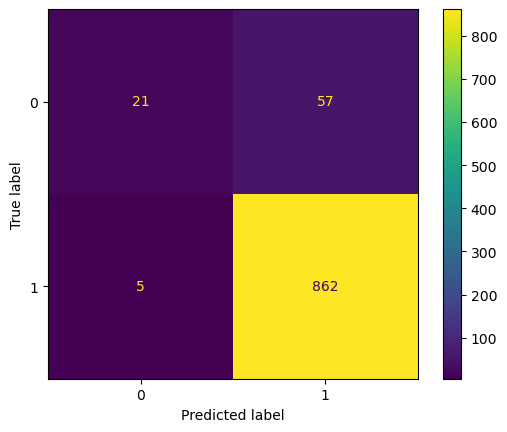

In [56]:
# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

# k fold cross validation

In [57]:
# Perform k-fold cross-validation
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)
print("Accuracy:", accuracies.mean())
print("Standard Variance:", accuracies.std())



Accuracy: 0.9382640888523242
Standard Variance: 0.006812427578174324


In [58]:
# Define the parameter grid for Random Forest
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}



In [59]:
# Create a Stratified K-Fold cross-validator
cv_object = StratifiedKFold(n_splits=2)

# Apply grid search to find the optimal parameters
grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [60]:

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}
Best Score: 0.9241944709561181


In [61]:
# Print the best parameters from the grid search
print("Best Parameter Combination:", grid_search.best_params_)

# Print cross-validation mean accuracy on the training set
print("Cross validation mean accuracy on train set: {:.2f}%".format(grid_search.cv_results_['mean_train_score'].mean() * 100))

# Print cross-validation mean accuracy on the test set
print("Cross validation mean accuracy on test set: {:.2f}%".format(grid_search.cv_results_['mean_test_score'].mean() * 100))

# Predict on the test set using the best model from grid search
y_preds = grid_search.predict(X_test_scl)

# Calculate accuracy score for the test set
print("Accuracy score for test set:", accuracy_score(y_test, y_preds))

Best Parameter Combination: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 100}
Cross validation mean accuracy on train set: 96.56%
Cross validation mean accuracy on test set: 92.24%
Accuracy score for test set: 0.9291005291005291


# XgBoost


In [62]:
# Initialize the XGBoost Classifier
model_xgb = XGBClassifier()

# Fit the model on the scaled training data
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [63]:
# Accuracy of the model on training data
train_accuracy = model_xgb.score(X_train_scl, y_train)
print("Training Accuracy:", train_accuracy)

# Accuracy of the model on testing data
test_accuracy = model_xgb.score(X_test_scl, y_test)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.9727644121652292
Testing Accuracy: 0.9333333333333333


In [64]:
# Predict on the test set
y_preds = model_xgb.predict(X_test)

In [65]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
cm

array([[ 20,  58],
       [  7, 860]], dtype=int64)

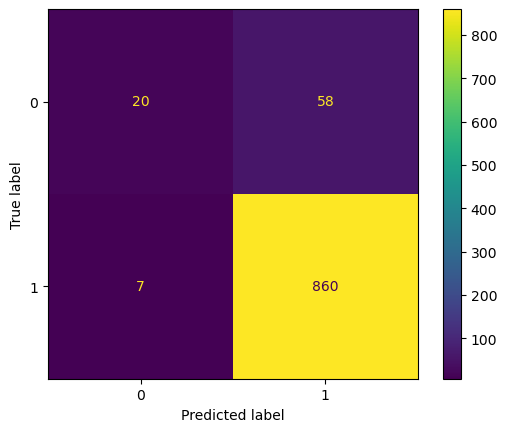

In [66]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [67]:
pickle.dump(model_xgb,open('Models/model_xgb.pkl','wb'))

# Decision tree Classifier

In [68]:
# Initialize the Decision Tree Classifier
model_dt = DecisionTreeClassifier()

# Fit the model on the scaled training data
model_dt.fit(X_train_scl, y_train)



DecisionTreeClassifier()

In [69]:
# Print the accuracy of the model on the training and testing data
print("Training Accuracy:", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy:", model_dt.score(X_test_scl, y_test))



Training Accuracy: 0.994098955969133
Testing Accuracy: 0.9259259259259259


In [70]:
# Predict on the test set
y_preds = model_dt.predict(X_test_scl)



In [71]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

print(cm)

[[ 38  40]
 [ 30 837]]


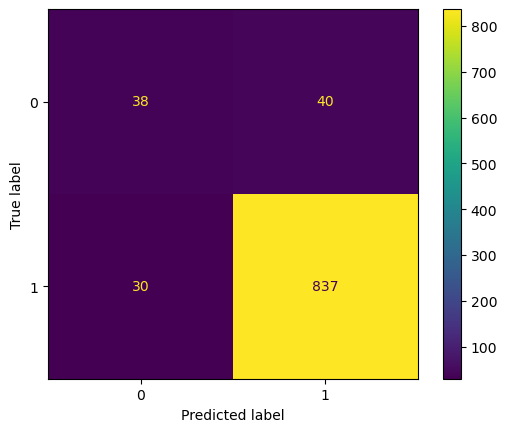

In [72]:
# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [73]:
pickle.dump(model_dt,open('Models/model_dt.pkl','wb'))